# Project Thus Far

The purpose of this project is to use data from [Twitter](https://twitter.com/), [Reddit](https://www.reddit.com/) and the stock market ([Yahoo! Finance](https://finance.yahoo.com/)) to get an idea of how people feel about a publicly traded stock, and generate a reasonable path of the stock price for the next week. The only required inputs are the name of the company of interest, and its ticker symbol.

This notebook serves as a simple proof of concept. It begins by fetching 10 tweets from Twitter about the company of interest. I compute a popularity score by using the number of likes and retweets the Tweet has. I then fetch the top 10 Reddit posts from three investing subreddits, and (at most) three subreddits related to the company of interest. I also filter for posts relevant to the company of interest. I then aggregate the data in a DataFrame, compute the sentiment of each post, and then compute the overall sentiment people have towards the company of interest.

Next, I scrape some statistics about the last month of the company's stock price from Yahoo! Finance, and plot the price movement over this time period. I use these statistics, and the overall sentiment people have towards the company of interest, to generate two distributions that are sampled from and combined to yield projected stock prices for the next week. The base distribution is a normal distribution, that has a mean of the last open stock price, and a standard deviation of the mean difference between the daily highs and lows of the stock over the previous month. The distribution is complemented by a uniform distribution which has at least one bound of 0. The other bound is the overall sentiment people have towards the company of interest scaled by a constant, divided by the average volume of traded stock for the past month. I then plot the last week's price movement, and a generated week of future price movement, by summing the values of the two above distributions.

## 1) Set Company of Interest

In [1]:
company_of_interest = "Microsoft"
company_of_interest_ticker = "MSFT"

## 2) Acquire Twitter Data About Company of Interest

In [2]:
import requests


twitter_search_endpoint = 'https://api.twitter.com/2/tweets/search/recent'
headers = {
    'Authorization' : 'Bearer <bearer_token>'
}
parameters  = {
    'query' : company_of_interest,
    'tweet.fields' : 'text,author_id,created_at,public_metrics',
}

res = requests.get(twitter_search_endpoint, headers=headers, params=parameters) 
tweets = res.json()
posts = []

for d in tweets["data"]:
    score = d["public_metrics"]["like_count"] + 10*d["public_metrics"]["retweet_count"]
    posts.append((d["id"], d["text"], score))

## 3) Acquire Reddit Data About Company of Interest

In [3]:
import praw


reddit = praw.Reddit(
    client_id="<client_id>",
    client_secret="<client_secret>",
    user_agent="<user_agent>",
)

subreddits = [reddit.subreddit('Trading'),
              reddit.subreddit('investing'),
              reddit.subreddit('stocks')]
subreddits_for_coi = reddit.subreddits.search_by_name(company_of_interest)
if subreddits_for_coi:
    subreddits.extend(subreddits_for_coi[:min(len(subreddits_for_coi), 3)])

for subreddit in subreddits:
    for submission in subreddit.hot(limit=10):
        if company_of_interest in submission.selftext:
            posts.append((submission.id, submission.selftext, submission.score))

## 4) Structure All Data in a DataFrame

In [4]:
import pandas as pd

df = pd.DataFrame(columns=["id", "text", "score"], data=posts)
df

,id,text,score
0,1454798187848425473,RT @windowsblog: Panos Panay and more: What’s ...,140
1,1454798180801941512,RT @SohoRonso: 【バックナンバー『雙峰論叢』第4号(2020年4月号)公開のお...,30
2,1454798173231357956,RT @ABC: The same actors behind the SolarWinds...,320
3,1454798151118999552,@Sawdog881 @9to5mac @joseadorno Microsoft has ...,0
4,1454798149126692864,RT @omarsar0: Data Science for Beginners - A C...,430
5,1454798142847782913,@Emill1984 @Fan_Technologii @Microsoft @debian...,1
6,1454798122069241860,RT @AlanBarrosoA: Aprovechando que es Hallowee...,580
7,1454798104688041984,Software/Tech Tip: Handout of Microsoft Word k...,0
8,1454798098715189248,@sunglasssister @LuciitheAlien Ty @Microsoft a...,0
9,1454798081245937666,RT @wan_1997: Laptop ni macam boleh bau je bil...,84170


## 5) Calculate Sentiment

In [5]:
from textblob import TextBlob


df["sentiment_score"] = df["text"].apply(lambda x: TextBlob(x).sentiment.polarity)

## 6) Aggregate Sentiment Scores

In [6]:
aggregate_sentiment = 0

for i, r in df.iterrows():
    aggregate_sentiment += r["score"] * r["sentiment_score"]

## 7) Yahoo Finance Visualization

In [7]:
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
import datetime


today = datetime.date.today()
start = (today - datetime.timedelta(days=30)).strftime("%Y-%m-%d")
end = today.strftime("%Y-%m-%d")

df_stock_prices = yf.download(company_of_interest_ticker, start, end)

[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'Last Monthly Stock Prices of Microsoft')

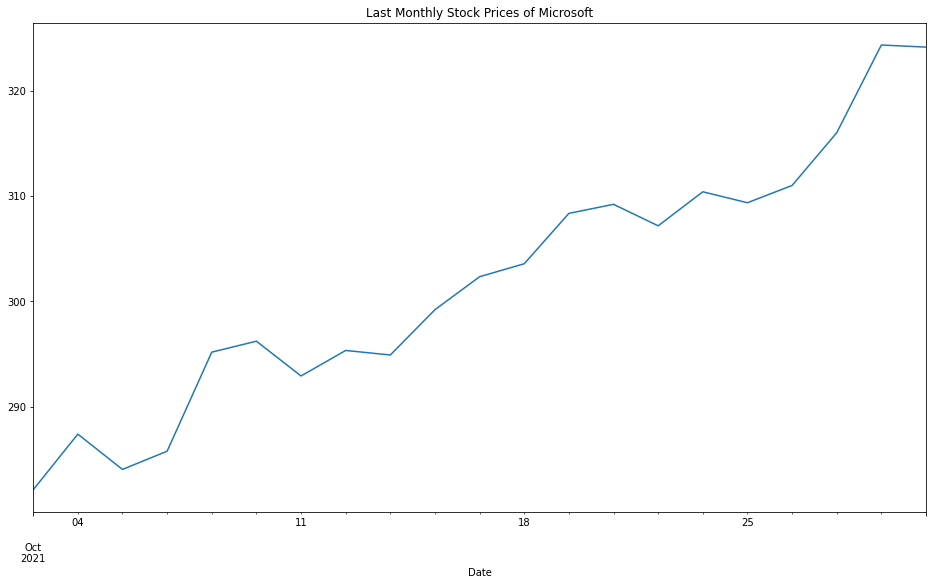

In [8]:
df_stock_prices["Open"].plot(label=company_of_interest, figsize = (16, 9))
plt.title(f"Last Monthly Stock Prices of {company_of_interest}")

## 8) Projection Visualization

In [9]:
df_future_stock_prices = df_stock_prices.copy()

mean_volume = df_stock_prices["Volume"].mean()
sentiment_scaled_by_volume = aggregate_sentiment * 100_000 / mean_volume if mean_volume != 0 else 0

In [10]:
import numpy as np


# main distribution: normal random variable with
#     - a mean of the previous Open
#     - a standard deviation of the average difference between High and Low for each day
high_low_diffs = [high - low for high, low in zip(df_stock_prices["High"], df_stock_prices["Low"])]
normal_std = sum(high_low_diffs) / len(high_low_diffs)

# sentiment noise: uniform random variable of sentiment scaled by volume
uniform_low, uniform_high = (0, sentiment_scaled_by_volume) if sentiment_scaled_by_volume > 0 else (sentiment_scaled_by_volume, 0)

Text(0.5, 1.0, 'Last Week and Projected Next Week of Stock Prices of Microsoft')

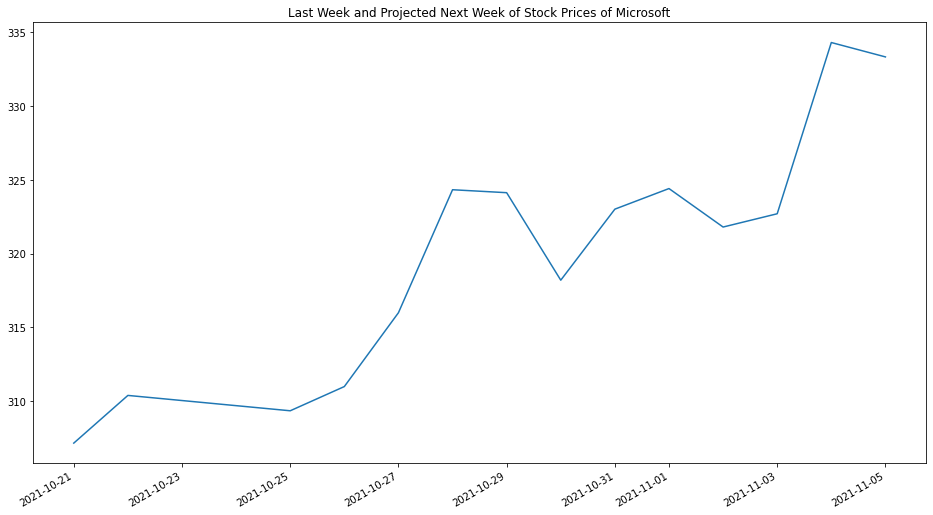

In [11]:
df_future_stock_prices.drop(columns=["High", "Low", "Close", "Adj Close", "Volume"], inplace=True)

for i in range(7):
    previous = df_future_stock_prices.iloc[-1]
    date = pd.to_datetime(previous.name + datetime.timedelta(days=1), format="%Y-%m-%d")
    new_row = pd.DataFrame(
        [[np.random.normal(previous["Open"], normal_std) + np.random.uniform(low=uniform_low, high=uniform_high)]],
        columns=["Open"],
        index=[date]
    )
    df_future_stock_prices = pd.concat([df_future_stock_prices, pd.DataFrame(new_row)], ignore_index=False)

df_future_stock_prices = df_future_stock_prices.iloc[-14:]

df_future_stock_prices["Open"].plot(label="future_" + company_of_interest, figsize = (16, 9))
plt.title(f"Last Week and Projected Next Week of Stock Prices of {company_of_interest}")